## Learning to Learn by gradient descent by gradient desent

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd, rmsprop

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss

from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17,7)
plt.style.use('default')

In [2]:
tf.__version__

'2.9.0'

In [15]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [4]:
class Quadratic():
    
    def __init__(self, random_seed, **kwargs):
        npr.seed(random_seed)
        self.W= npr.normal(loc = 0.0, scale = 1e0, size=(10,10))
        self.y = npr.normal(loc = 0.0, scale = 1e0, size=(10,1))
        
        self.theta = np.linalg.inv(self.W) @ self.y 
        # calculated value of theta that minimizes loss
        # reutrned value must be very close, element-wise
        
    def __call__(self, theta):
        return np.mean(np.sum((self.W @ theta - self.y)**2, axis=1))
    
    def grad(self, theta):
        return grad(self.__call__)(theta)

In [5]:
class QuadraticLoss(Loss):
    
    def __init__(self, random_seed):
        super().__init__()
        npr.seed(random_seed)
        self.W= npr.normal(loc = 0.0, scale = 1e0, size=(10,10))
        self.y = npr.normal(loc = 0.0, scale = 1e0, size=(10,1))
        
    def call(self, theta, required = None):
        return tf.math.reduce_mean(tf.math.reduce_sum((self.W@theta-self.y)**2, axis=1))

In [7]:
class LSTMOpt(Model):
    
    """
    The optimizer defined here matches the one in the paper to the best of my interpretation.
    """
    
    def __init__(self, **kwargs):
        
        super(LSTMOpt, self).__init__(**kwargs)
        self.lstm1 = LSTM(20, 
                          return_state=True, 
                          return_sequences=True)
        
        self.lstm2 = LSTM(20, 
                          return_state=True)
        
        self.dense1 = Dense(1, 
                            name='1 dimensional update')
    
        
    def call(self, gradients, states):
        
        if states == None:
            h1,c1,h2,c2 = tf.zeros([10,20]), tf.zeros([10,20]), tf.zeros([10,20]), tf.zeros([10,20])
        else:
            h1,c1,h2,c2 = states
            
        if gradients == None:
            gradients = tf.zeros([10,1,1])
        else:
            gradients = tf.reshape(gradients, [10,1,1])
        
        seq, h1, c1 = self.lstm1(gradients, initial_state = [h1, c1])
        seq, h2,c2 = self.lstm2(seq, initial_state = [h2,c2])
        update = self.dense1(seq)
                        
        states = [h1, c1, h2, c2]
                      
        return update, states

In [8]:
def Fit_learned(model, quadratic_class, loss_class, lr = 0.003, num_diff_functions = 100, optimize_each_for_steps = 100, unrolls = 20):
    
    states = None
    meta_optimizer = tf.keras.optimizers.Adam(0.005)
    
    for func in tqdm(range(num_diff_functions), 'Number of Functions Optimized'):
        
        Quadratic = quadratic_class(func)
        loss = loss_class(func) # initialize the loss object
        
        theta =tf.random.normal(shape=(10,1))
        optimizee_gradients = Quadratic.grad(theta.numpy())
        
        
        sum_losses = tf.zeros(())
        for steps in range(optimize_each_for_steps):
            
            with tf.GradientTape() as tape:
                    update, states = model(optimizee_gradients, states)
                    theta += update
                    sum_losses += loss(theta, None)
                    
            optimizee_gradients = Quadratic.grad(theta.numpy())
            
            if (steps+1) % unrolls == 0:
                lstm_grads = tape.gradient(sum_losses, model.variables)
                meta_optimizer.apply_gradients(zip(lstm_grads, model.variables))
                sum_losses = tf.zeros(())

In [9]:
def Evaluate_learned(model, quadratic_class, seed, num_diff_functions = 100, optimize_each_for_steps = 100, should_plot = False):
    
    states = None

    loss_progression = np.zeros([num_diff_functions, optimize_each_for_steps])

    for func in tqdm(range(num_diff_functions), 'Number of Functions Evaluated'):
        
        Quadratic = quadratic_class(seed + func)

        theta = tf.random.normal(shape=(10,1))
        
        optimizee_gradients = Quadratic.grad(theta.numpy())

        for steps in range(optimize_each_for_steps):
            
            loss_progression[func, steps] = Quadratic(theta)
        
            update, states = model(optimizee_gradients, states)
            
            theta += update
                    
            optimizee_gradients = Quadratic.grad(theta.numpy())
                    
                
    
    mean_losses = np.mean(loss_progression, axis = 0)
    
    if should_plot:
        
        plt.style.use('default')
        fig, ax = plt.subplots(figsize = (7,4))
        ax.semilogy(mean_losses)
        ax.grid()
        ax.set_xlabel("Iterations")
        ax.set_ylabel(f"Average Loss of {num_diff_functions} functions")
        fig.suptitle("Mean Losses vs Iterations");
        
    return mean_losses

In [10]:
def Solve_learned(model, Quad_object, iterations = 100, theta = None):
    '''
    takes one instance of quadratic class and 'Solves' that optimization problem.
    returns the found_optimal and losses per epoch as a python list
    '''
    
    if theta is None:
        theta = tf.random.normal(shape=(10,1))
        
    losses = []
    optimizee_gradients = Quad_object.grad(theta.numpy())
    states = None
    
    for _ in tqdm(range(iterations), 'Iterations'):
        
        losses.append(Quad_object(theta))
        update, states = model(optimizee_gradients, states) 
        theta += update
        optimizee_gradients = Quad_object.grad(theta.numpy())
          
    return theta, losses

In [11]:
def Evaluate_others(quadratic_class, seed, lr = 0.003, num_diff_functions = 100, optimize_each_for_steps = 100, should_plot = False):
    
    optimizers = [sgd, adam, rmsprop]
    
    loss_optimizers = np.zeros([len(optimizers), optimize_each_for_steps])
    loss_progression = np.zeros([num_diff_functions, optimize_each_for_steps])
    
    if should_plot:
            fig, ax = plt.subplots(figsize = (8,5))
            fig.suptitle(f"Loss vs Iterations for Adam, SGD, RMSProp, LR: {lr}")
            ax.grid()
            ax.set_xlabel("Iterations")
            ax.set_ylabel(f"Average Loss of {num_diff_functions} functions")

        
    for i in tqdm(range(len(optimizers)), "Optimizers"):
        
        optimizer = optimizers[i]
        
        for func in range(num_diff_functions):
            
            theta = theta =tf.random.normal(shape=(10,1)).numpy()
            q = quadratic_class(func+seed)
            
            def grad_func(theta, iter=0):
                return q.grad(theta)
            
            def append_loss(params, iter, gradient):
                loss_progression[func, iter] = q(params)
        
            theta = optimizer(grad_func, 
                              theta,
                              step_size = lr,
                              num_iters = optimize_each_for_steps, 
                              callback = append_loss)
            
        loss_optimizers[i, :] = np.mean(loss_progression, axis = 0)
        
        if should_plot:
            ax.semilogy(loss_optimizers[i, :])
            
    if should_plot:
        ax.legend(['sgd', 'adam', 'rmsprop'])
    
    return loss_optimizers

In [12]:
def Evaluate(model, Quadratic_class, random_seed, numFunctions, stepsOfOptimization, lr_for_other, should_plot = True):
    
    loss_optimizers = Evaluate_others(Quadratic_class, 
                                      seed = random_seed, 
                                      lr = lr_for_other, 
                                      num_diff_functions = numFunctions, 
                                      should_plot = False, 
                                      optimize_each_for_steps = stepsOfOptimization)
    
    lstm_losses = Evaluate_learned(model, 
                                   Quadratic_class, 
                                   seed = random_seed, 
                                   num_diff_functions = numFunctions, 
                                   should_plot = False, 
                                   optimize_each_for_steps = stepsOfOptimization)
    
    fig, ax = plt.subplots(figsize = (10, 7))
    
    ax.grid()
    ax.set_xlabel("Iterations")
    ax.set_ylabel(f"Average Loss of {numFunctions} functions")
        
    fig.suptitle("Adam vs. SGD vs. RMS Prop. vs. L2L")
    
    for loss in loss_optimizers:
        ax.semilogy(loss)
        
    ax.semilogy(lstm_losses)
    ax.legend(['sgd', 'adam', 'rmsprop', 'lstm'])


In [13]:
lstm = LSTMOpt()
Fit_learned(lstm, Quadratic, QuadraticLoss)

Number of Functions Optimized: 100%|██████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


Number of Functions Evaluated: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.96it/s]


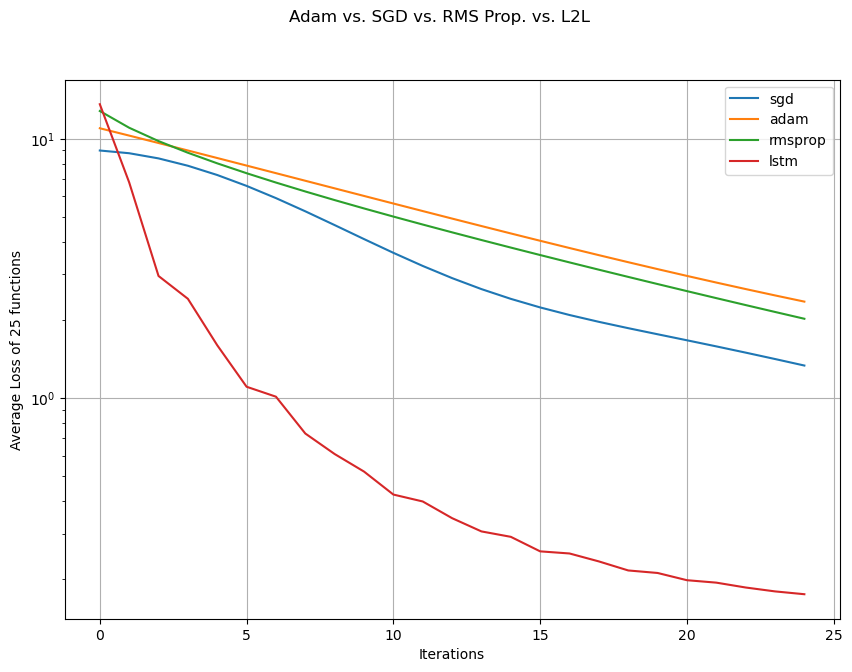

In [14]:
Evaluate(lstm, Quadratic, 501, 25, 25, .03, True)